**IMPORT LIBRARIES AND DATASET**


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [8]:
import os
# import cv2
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
XRay_Directory ='/content/drive/My Drive/Chest_X_Ray/train'

In [11]:
# List the folders in the directory
os.listdir(XRay_Directory)

['2', '3', '0', '1']

In [12]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # assuming you want to use 20% of data for validation


In [13]:
train_generator = image_generator.flow_from_directory(batch_size =40,
                                                      directory= XRay_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode = 'categorical',
                                                      subset='training')

Found 5978 images belonging to 4 classes.


In [14]:
validation_generator = image_generator.flow_from_directory(batch_size =40,
                                                      directory= XRay_Directory,
                                                      shuffle= True,
                                                      target_size=(256,256),
                                                      class_mode = 'categorical',
                                                      subset='validation')

Found 1493 images belonging to 4 classes.


In [15]:
# Generate a batch of 40 images and labels
!pip install pillow
train_images, train_labels = next(train_generator)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

In [17]:
# labels Translator
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Bacterial Pneumonia', 3 : 'Viral Pneumonia'}

**DATA VISUALIZATION**

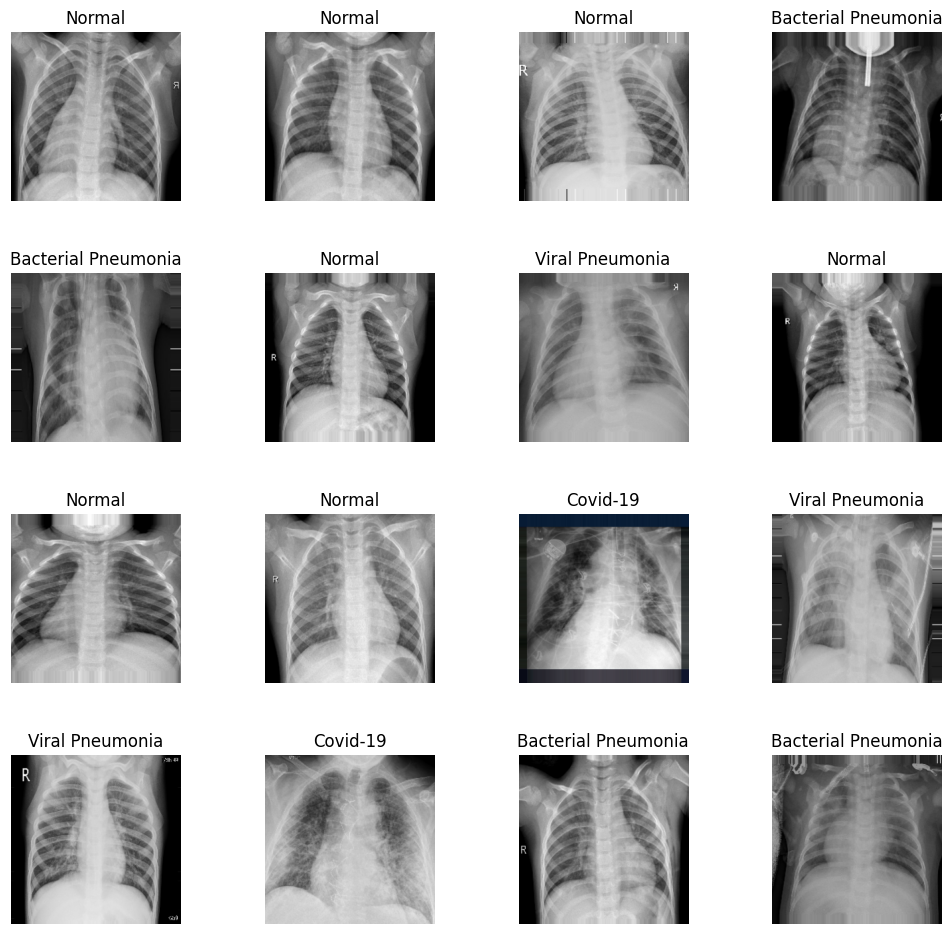

In [18]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

**IMPORT MODEL WITH PRETRAINED WEIGHTS**

In [19]:
basemodel = ResNet50(weights = 'imagenet' , include_top = False, input_tensor= Input (shape = (256,256,3)))

In [20]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [21]:
#freezing the model upto the last stage - 4 and re-training stage -5

for layer in basemodel.layers[:-10]:
  layers.trainable = False

**TRAIN RESNET MODEL WITH THE NEW DATASETS**

In [22]:
from tensorflow.keras import regularizers

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel= Flatten(name ='flatten')(headmodel)
headmodel= Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(headmodel)
headmodel= BatchNormalization()(headmodel)
headmodel= Dropout(0.3)(headmodel)
headmodel= Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(headmodel)
headmodel= Dropout(0.2)(headmodel)
headmodel= Dense(4, activation='softmax')(headmodel)
model = Model(inputs=basemodel.input, outputs=headmodel)


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,  # Number of steps before decay
    decay_rate=0.96,  # Decay rate
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
    metrics=["accuracy"]
)


In [25]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [26]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 5978 images belonging to 4 classes.
Found 1493 images belonging to 4 classes.


In [27]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 20, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/20
1494/1494 [==============================] - ETA: 0s - loss: 4.4498 - accuracy: 0.6491
Epoch 1: val_loss improved from inf to 2.24093, saving model to weights.hdf5
1494/1494 [==============================] - 481s 287ms/step - loss: 4.4498 - accuracy: 0.6491 - val_loss: 2.2409 - val_accuracy: 0.7889
Epoch 2/20
1494/1494 [==============================] - ETA: 0s - loss: 1.8428 - accuracy: 0.7325
Epoch 2: val_loss improved from 2.24093 to 1.50874, saving model to weights.hdf5
1494/1494 [==============================] - 420s 281ms/step - loss: 1.8428 - accuracy: 0.7325 - val_loss: 1.5087 - val_accuracy: 0.7460
Epoch 3/20
1494/1494 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.7611
Epoch 3: val_loss improved from 1.50874 to 1.14529, saving model to weights.hdf5
1494/1494 [==============================] - 411s 275ms/step - loss: 1.2603 - accuracy: 0.7611 - val_loss: 1.1453 - val_accuracy: 0.7822
Epoch 4/20
1494/1494 [==============================] - 

In [34]:
# Load the saved model weights
model.load_weights('weights.hdf5')

# Continue training
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.n // 4,
    epochs = 5,
    validation_data= val_generator,
    validation_steps= val_generator.n // 4,
    callbacks=[checkpointer, earlystopping]
)


Epoch 1/5
1494/1494 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8547
Epoch 1: val_loss did not improve from 0.32946
1494/1494 [==============================] - 413s 276ms/step - loss: 0.4132 - accuracy: 0.8547 - val_loss: 0.9637 - val_accuracy: 0.6857
Epoch 2/5
1494/1494 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.8540
Epoch 2: val_loss did not improve from 0.32946
1494/1494 [==============================] - 410s 274ms/step - loss: 0.4114 - accuracy: 0.8540 - val_loss: 0.5085 - val_accuracy: 0.8398
Epoch 3/5
1494/1494 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8555
Epoch 3: val_loss did not improve from 0.32946
1494/1494 [==============================] - 408s 273ms/step - loss: 0.4070 - accuracy: 0.8555 - val_loss: 0.3421 - val_accuracy: 0.8908
Epoch 4/5
1494/1494 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8611
Epoch 4: val_loss did not improve from 0.32946
1494/1494 [==

In [35]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [39]:
# Let's compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
test_directory ='/content/drive/My Drive/Chest_X_Ray/test'

In [48]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 1740 images belonging to 4 classes.


<ipython-input-48-15440cd26711>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


 44/435 [==>...........................] - ETA: 43:16 - loss: 0.4009 - accuracy: 0.8494

435/435 [==============================] - 291s 659ms/step - loss: 0.4009 - accuracy: 0.8494
Accuracy Test : 0.8494253158569336


In [49]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 33ms/step


In [51]:
len(original)

1740

In [52]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8591954022988506


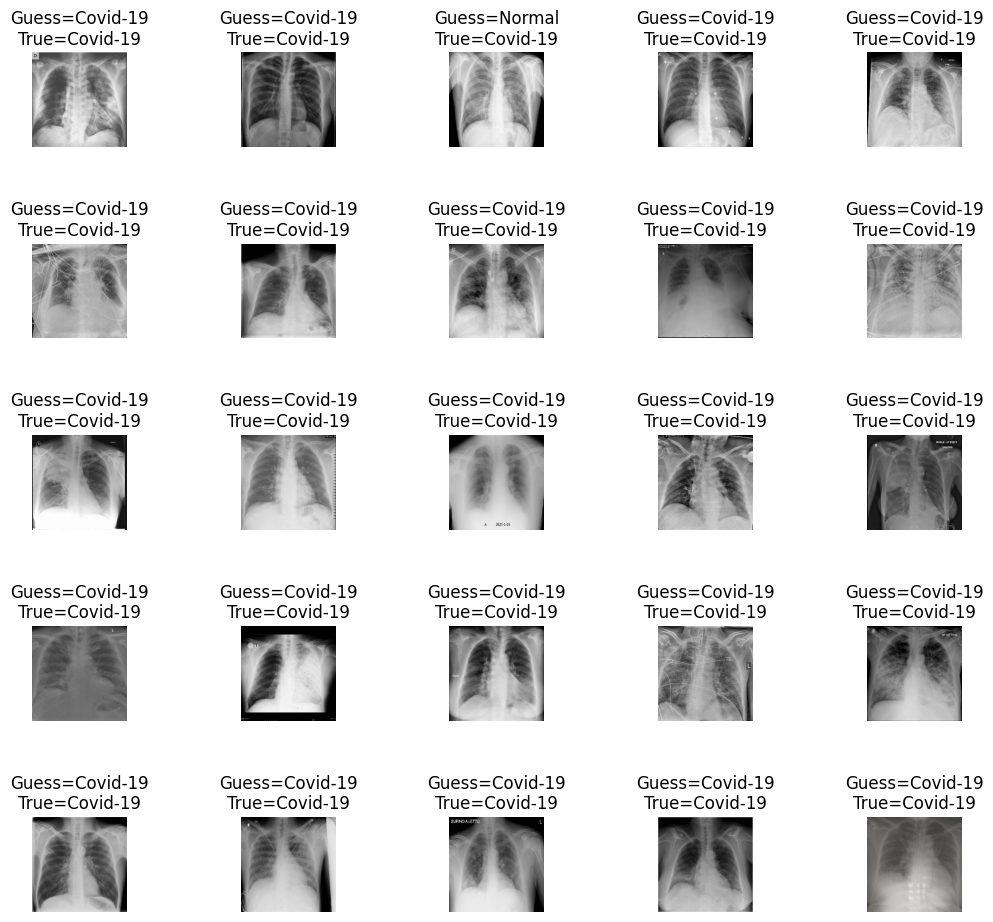

In [53]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [54]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       240
           1       0.95      1.00      0.98       609
           2       0.85      0.74      0.79       570
           3       0.63      0.72      0.67       321

    accuracy                           0.86      1740
   macro avg       0.85      0.86      0.85      1740
weighted avg       0.86      0.86      0.86      1740



Text(0.5, 1.0, 'Confusion_matrix')

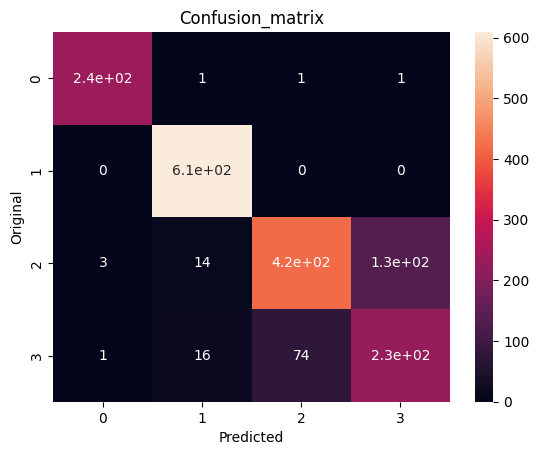

In [55]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')